## Chapter 5: Linear regression

# 5.8  Multi-output regression

Thus far we have assumed that datapoints for linear regression consist of $N$ dimensional *vector valued* inputs and *scalar-valued* outputs.  That is, a prototypical datapoint takes the form  $\left(\mathbf{x}_p,\,y_p\right)$ where $\mathbf{x}_p$ is an $N$ dimensional *input vector* $\mathbf{x}_p$ and a *scalar* output $y_p$.  While this configuration covers the vast majority of regression cases one may well encounter in practice, it is possible to perform (linear) regression where both *input* and *output* are *vector-valued*.  This is often called *multiple-output regression*, and in this Section we describe how to extend the basic elements of this Chapter to properly handle it.

In [17]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib

# demos for this notebook
plotter = superlearn.multi_outupt_plotters
static_plotter = optlib.static_plotter.Visualizer()
optimizers = optlib.optimizers
datapath = '../../mlrefined_datasets/superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

## 5.8.1  Notation and modeling

Suppose now that instead of being *scalar-valued* the output of a regression dataset were *vector-valued*.  That is our datapoints 

\begin{equation}
 \left(\mathbf{x}_{1}^{\,},\mathbf{y}_{1}^{\,}\right),\,\left(\mathbf{x}_{2}^{\,},\mathbf{y}_{2}^{\,}\right),\,...,\,\left(\mathbf{x}_{P}^{\,},\mathbf{y}_{P}^{\,}\right)
\end{equation}

have both *vector-valued* input *and* output.  The $p^{th}$ point $\left(\mathbf{x}_{p}^{\,},\mathbf{y}_{p}^{\,}\right)$ has $N$ dimensional input $\mathbf{x}_p$ and associated $C$ dimensional output $\mathbf{y}_p$.  While in principle we can treat $\mathbf{y}_p$ as a $P \ times 1$ column vector, in order to keep the formulae that follows looking similar to what we have already seen in the scalar case we will treat the *input* as a $N\times 1$ *column* vector and the output as a $1 \times C$ *row* vector as

\begin{equation}
\mathbf{x}_{p}=\begin{bmatrix}
x_{1,p}\\
x_{2,p}\\
\vdots\\
x_{N,p}
\end{bmatrix}  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  
\mathbf{y}_{p}=\begin{bmatrix}
y_{1,p} &
y_{2,p} &
\cdots &
y_{C,p}
\end{bmatrix}.
\end{equation}

Now, notice that to suppose that a *linear* relationship holds between the input $\mathbf{x}_p$ and *just* the scalar-valued $c^{th}$ dimension of the output $y_{c,p}$ of such a dataset results in precisely the sort of regression framework we have seen thus far.  That is if we denote

\begin{equation}
\mathbf{w}_c=\begin{bmatrix}
w_{0,c}\\
w_{1,c}\\
w_{2,c}\\
\vdots\\
w_{N,c}
\end{bmatrix}
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\mathring{\mathbf{x}}_p=\begin{bmatrix}
1 \\
x_{1,p}\\
x_{2,p}\\
\vdots\\
x_{N,p}
\end{bmatrix},\,\,\,\, p = 1,...,P
\end{equation}

where $\mathbf{w}_c$ is a set of weights then - if these are tuned properly - then the assumption of a linear relationship looks like precisely what we have seen starting in Section 8.1
 
\begin{equation}
\mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{w}}_{c}^{\,}    \approx \overset{\,}{y}_{c,p}^{\,} \,\,\,\,\,\,\,\,\,\,\,    \,\,\,\,\,\,\,\,\,\,\, p=1,...,P.
\end{equation}

Then let us suppose that a linear relationship holds between the input and all $C$ entries of the output.  If we place each weight vector $\mathbf{w}_c$ into the $c^{th}$ column of the $\left(N+1\right) \times C$ *weight matrix* $\mathbf{W}$ as

\begin{equation}
\mathbf{W}=\begin{bmatrix} 
w_{0,0}  &  w_{0,1}  &  w_{0,2}  & \cdots   &  w_{0,C}  \\
w_{1,0}  &  w_{1,1}  &  w_{1,2}  & \cdots  &   w_{1,C}  \\
w_{2,0}  &  w_{2,1}  &  w_{2,2}  & \cdots  &  w_{2,C}  \\
\,\,\, {\vdots}_{\,\,\,}  & {\vdots}_{\,\,\,}  &  {\vdots}_{\,\,\,}  &  \cdots   &    {\vdots}_{\,\,\,}    \\
w_{N,0}  &  w_{N,1} & w_{N,2}  &  \cdots  &  w_{N,C}  \\
\end{bmatrix}
\end{equation}

then the entire set of $C$ linear models can be written compactly as $1\times C$ vector-matrix product

\begin{equation}
\begin{matrix}  \mathring{\mathbf{x}}_p^T\mathbf{W} \end{matrix}  = \begin{bmatrix}
\mathring{\mathbf{x}}_p^T  \overset{\,}{\mathbf{w}}_{1}^{\,}   &
\mathring{\mathbf{x}}_p^T  \overset{\,}{\mathbf{w}}_{2}^{\,}   &
\cdots \, &
\mathring{\mathbf{x}}_p^T  \overset{\,}{\mathbf{w}}_{C}^{\,}
\end{bmatrix}
\end{equation}

and then the entire set of $C$ linear relationships can likewise be written as 

\begin{equation}
\mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{W}}_{\,}^{\,}    \approx \overset{\,}{\mathbf{y}}_{p}^{\,} \,\,\,\,\,\,\,\,\,\,\,    \,\,\,\,\,\,\,\,\,\,\, p=1,...,P.
\end{equation}

But of course this approximation $\approx$ only truly holds if we can tune the weights $\mathbf{W}$ properly.  To do this we can invoke any regression cost function - e.g., the Least Squares or Least Absolute Deviations - and properly minimize in order to make this approximation hold as well as possible.

## 5.8.2  Cost functions

The thought process involved in deriving a regression cost function for the case of multi-output regression mirrors almost exactly the scalar-output case discussed in Sections 8.1 and 8.2.  For example, to derive a Least Squares cost function we begin in the same way we did in Section 8.1 - by taking the difference of both sides in equation (6) above.  However now the error associated with the $p^{th}$ point, written as $\mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{W}}_{\,}^{\,}    - \overset{\,}{\mathbf{y}}_{p}^{\,}$, has $C$ values.  To square this error we must employ the *squared* $\ell_2$ norm, which is a natural extension of the squaring operation $\left(\cdot\right)^2$ to vectors (described further in Appendix Section).  The Least Squares cost function in this case is then the average of the $\ell_2$ norm of each point's error as

\begin{equation}
 g\left(\mathbf{W}\right) = \frac{1}{P}\sum_{p=1}^{P} \left \Vert \mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{W}}_{\,}^{\,}    - \overset{\,}{\mathbf{y}}_{p}^{\,} \right \Vert_2^2 = \frac{1}{P}\sum_{p=1}^{P} \sum_{c=1}^{C} \left( \mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{w}}_{c}^{\,}   - \overset{\,}{y}_{c,p}^{\,}   \right)^2
\end{equation}

When the output takes on scalar value, that is when $C=1$, this reduces to the Least Squares cost we saw in Section 8.1.

Likewise the analagous Least Absolute Deviations (which measures the absolute value of each error as opposed to its square) cost for our present case takes the form

\begin{equation}
 g\left(\mathbf{W}\right) = \frac{1}{P}\sum_{p=1}^{P} \left \Vert \mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{W}}_{\,}^{\,}    - \overset{\,}{\mathbf{y}}_{p}^{\,} \right \Vert_1 = \frac{1}{P}\sum_{p=1}^{P} \sum_{c=1}^{C} \left\vert \mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{w}}_{c}^{\,}   - \overset{\,}{y}_{c,p}^{\,}   \right\vert
\end{equation}

where $\left\Vert \cdot \right \Vert_1$ is the $\ell_1$ norm, the generalization of the absolute value function for vectors (see the Appendix Section for further information).

These cost functions - like their scalar-valued output analogs - are alwasy convex *regardless of the dataset used*.

## 5.8.3  Implementing cost functions in `Python`

Because `Python` has such flexible sytax, we can implement the linear model

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{W}\right) =
\mathring{\mathbf{x}}^T\mathbf{W}^{\,} 
\end{equation}

precisely as we have done before.  In *implementing* this linear combination we need not form the adjusted input $\mathring{\mathbf{x}}_{p}$ (by tacking a $1$ on top of the raw input $\mathbf{x}_p$) and can more easily compute the linear combination by exposing the biases as

\begin{equation}
\mathring{\mathbf{x}}_{p}^T \mathbf{W} = \mathbf{W}_{[0]}^{\,} + \mathbf{x}_p^T \mathbf{W}_{[1:]}^{\,}.
\end{equation}

The meaning of the subscripts used here match `Pythonic` slicing notation (and the implementation given below), which we implement in `Python` analagously as

                                a = w[0] + np.dot(x_p.T,w[1:])

That is $\mathbf{W}_{[0]}$ denotes the first *row* of $\mathbf{W}$ (containing the biases of all $C$ linear combinations) and $\mathbf{W}_{[1:]}$ denotes the final $N$ rows (all feature touching weights of all linear combinations).  The only new thing to keep in mind here is that, in the `Python` implementation below, we now denote $\mathbf{W}$ by the variable `w`.

In [2]:
# compute linear combination of input points
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

`Pythonic` implementation of regression cost functions can also be implemented precisely as we have seen previously.  For example, the Least Squares cost can be written as shown below.

In [3]:
# an implementation of the least squares cost function for linear regression
def least_squares(w):    
    # compute the least squares cost
    cost = np.sum((model(x,w) - y)**2)
    return cost/float(np.size(y))

#### <span style="color:#a50e3e;">Example 1: </span> Fitting a linear model to a multi-output regression dataset

In this example we show an example of multi-output linear regression using a toy dataset with input dimension $N=2$ and output dimension $C=2$.  The dataset is shown below.

<IPython.core.display.Javascript object>


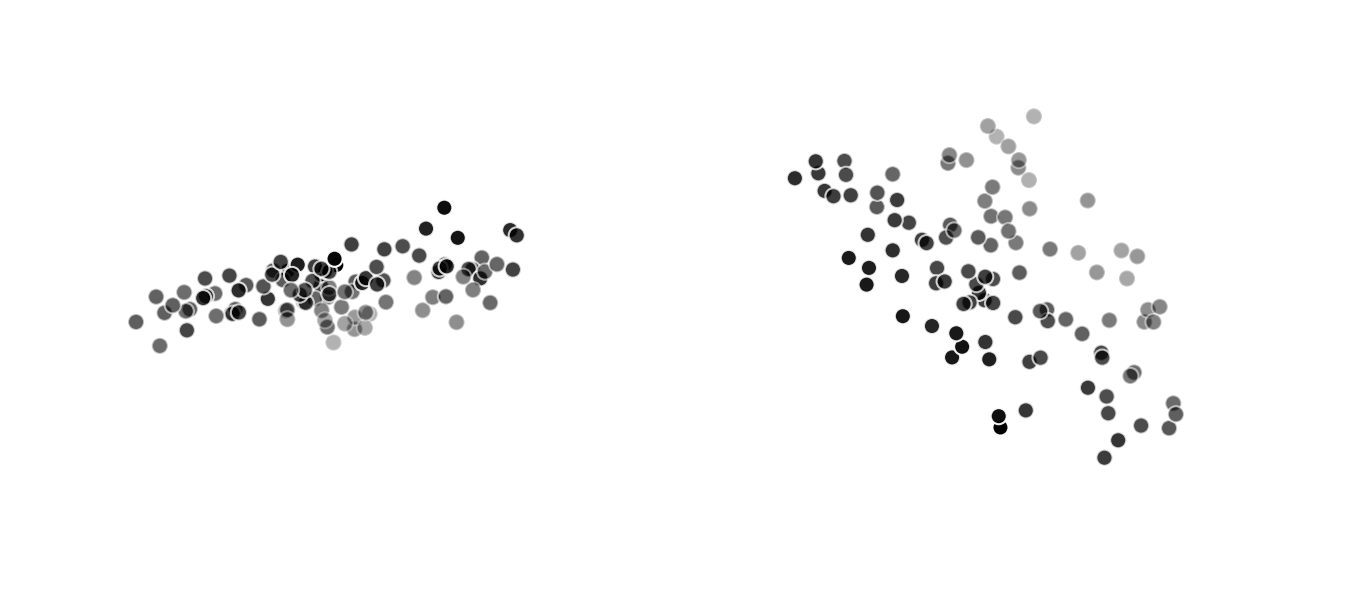

In [6]:
## This code cell will not be shown in the HTML version of this notebook
# load in data
csvname = datapath + 'linear_2output_regression.csv'
data = np.loadtxt(csvname,delimiter=',')
x = data[:2,:]
y = data[2:,:]

# plot
plotter.plot_data(x,y)

We use the `Pythonic` Least Squares function shown above, minimizing it using $200$ steps of gradient descent using a steplength / learning rate $\alpha = 1$.  The cost function history from this run is shown below.

<IPython.core.display.Javascript object>


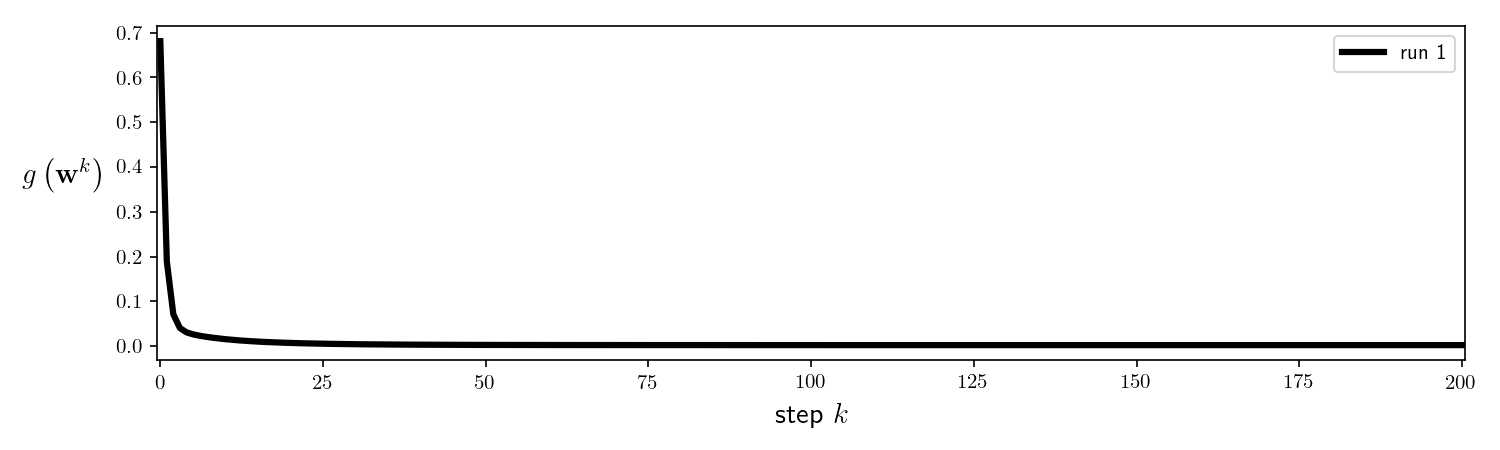

In [20]:
## This code cell will not be shown in the HTML version of this notebook
# setup and run optimization
g = least_squares; 
w = 0.1*np.random.randn(3,2)
max_its = 200;
alpha_choice = 1;
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# plot history
static_plotter.plot_cost_histories([cost_history],start = 0,points = False,labels = ['run 1'])

Using the fully trained model from this run of gradient descent (implemented as shown in Section 8.4.3) we evaluate a fine mesh of points in the region over which the input of this dataset is defined to visualize our linear approximations.  These are shown in light green in the panels below.

<IPython.core.display.Javascript object>


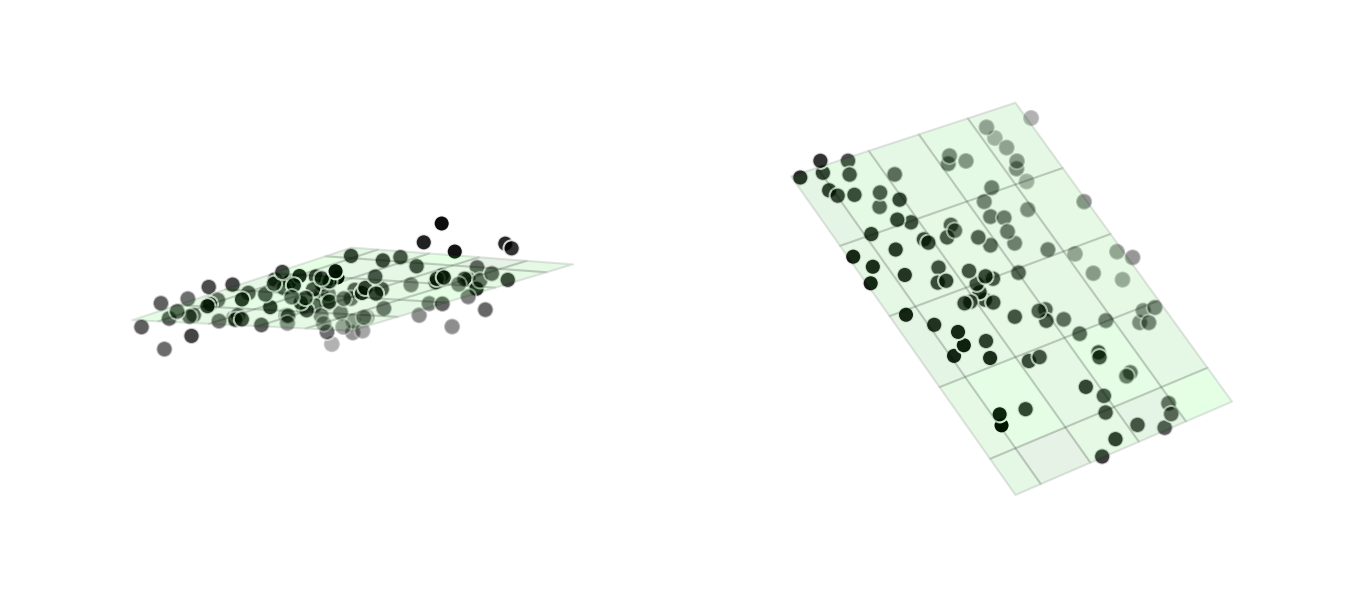

In [23]:
## This code cell will not be shown in the HTML version of this notebook
# determine best weights - based on lowest cost value attained
ind = np.argmin(cost_history)
w_best = weight_history[ind]

# form predictor
predictor = lambda x: model(x,w_best)

# plot data with predictions
plotter.plot_regressions(x,y,predictor)

&copy; This material is not to be distributed, copied, or reused without written permission from the authors.